In [105]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

In [106]:
start = pd.to_datetime('2010-08-02')
end = pd.to_datetime('2018-08-02')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
data.reset_index(inplace = True)
data = data[['Open', 'High','Low', 'Close', 'Volume']]
print(data.head())


y = pd.DataFrame()

for i in range(len(data) - 1):
    if data.loc[i + 1, 'Open'] - data.loc[i, 'Close'] > 0:
        y.loc[i, 0] = 1
    else:
        y.loc[i, 0] = 0

print(y)      

print(len(data))
data_train = data.iloc[0:1601,] 
data_test = data.iloc[1601:2001,]
print(len(data_train))
print(len(data_test))

y_train = y.iloc[0:1601,] 
y_test = y.iloc[1601:2001,]

[*********************100%***********************]  1 of 1 completed
        Open       High        Low      Close     Volume
0  12.179100  12.285949  12.128041  12.214467   74626675
1  12.216709  12.265526  12.123558  12.200021   72362219
2  12.258552  12.627668  12.230407  12.610732  153071607
3  12.600022  12.667519  12.541990  12.655066   97178890
4  12.587818  12.596286  12.354941  12.458801  133277692
        0
0     1.0
1     1.0
2     0.0
3     0.0
4     1.0
...   ...
2009  0.0
2010  1.0
2011  0.0
2012  1.0
2013  1.0

[2014 rows x 1 columns]
2015
1601
400


<Axes: >

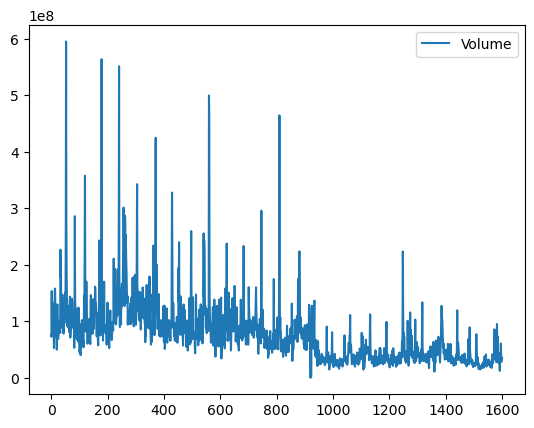

In [107]:
seaborn.lineplot(data_train.loc[:,["Volume"]]) #plot the value of close

<Axes: >

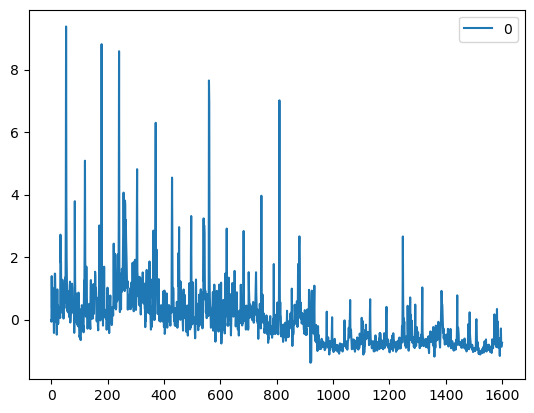

In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train.loc[:,["Volume"]])
test = scaler.transform(data_train.loc[:,["Volume"]])
seaborn.lineplot(test)

In [109]:
def preprocess_exp(data):
    # use the estimates to calculate the curve
    preprocessed = pd.DataFrame()
    PF = pd.DataFrame()
    
    for col in ['Open', 'High', 'Low', 'Close']:
        PF = np.polyfit(data.index, np.log(data.loc[:, col]), 1)
        # divide by trend
        str_col = col + 'NoExp'
        preprocessed[str_col] = data[col] / (np.exp(PF[0] * data.index + PF[1]))

    return preprocessed

<Axes: >

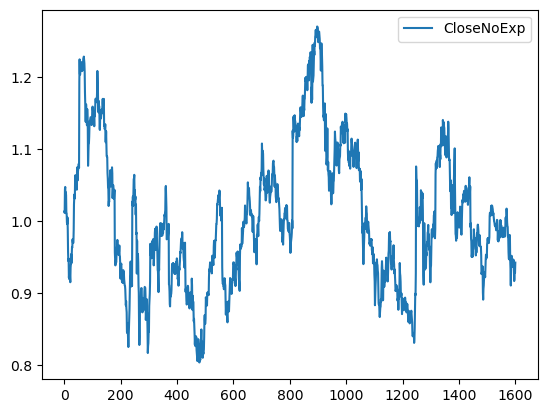

In [110]:
preprocessed = preprocess_exp(data_train)
# plot the line with the trend removed
seaborn.lineplot(preprocessed[["CloseNoExp"]])

In [111]:
##Multivariate RNN
cutOff = 1300 
preprocessed = np.array(preprocess_exp(data_train))
print(preprocessed)

validation = preprocessed[cutOff:]
train = preprocessed[:cutOff]

size_train = len(train)
size_validation = len(validation)

x_train = np.reshape(train, (len(train), 1, 4))
y_train = y[:cutOff]

x_validation = np.reshape(validation, (len(validation), 1, 4))
y_validation = y[cutOff:cutOff + size_validation]

[[1.01017276 1.01057947 1.01498763 1.01334942]
 [1.01251837 1.0081295  1.01383762 1.01137804]
 [1.0152104  1.03710254 1.02199184 1.04462759]
 ...
 [0.92698006 0.92733266 0.92938673 0.93317587]
 [0.9348538  0.93260505 0.9341536  0.92829336]
 [0.92958357 0.93495977 0.93154215 0.94234552]]


In [112]:
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.SimpleRNN(120, input_shape = (x_train.shape[1], x_train.shape[2]), activation="relu"))
model.add(layers.Dense(1, activation = "relu"))

# model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                #    activation=['tanh', 'tanh'])
# model.fit(x_data, y_data, epochs=20, batch_size=1, verbose=2)

model.summary()

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=100, epochs= 20)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 120)               15000     
                                                                 
 dense_7 (Dense)             (None, 1)                 121       
                                                                 
Total params: 15,121
Trainable params: 15,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
13/13 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.4515
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5485 - accuracy: 0.4515
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5485 - accuracy: 0.4515
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5485 - accuracy: 0.4515
Epoch 5/20
13/13 [==============================] - 0

In [113]:
predictTrain = model.predict(x_train)
predictValidation = model.predict(x_validation)
print(len(x_train), len(x_validation))
print(len(data))

10/10 [==============================] - 0s 738us/step
1300 301
2015


In [114]:
modelResults = pd.DataFrame()
modelResults["realValues"] = np.append(y_train, y_validation)
modelResults["estimatedValues"] = np.append(predictTrain, predictValidation)
for i in range(len(modelResults)):
    if modelResults.loc[i, "estimatedValues"] > 0.5:
        modelResults.loc[i, "estimatedValues"] = 1
    else:
        modelResults.loc[i, "estimatedValues"] = 0

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.array(modelResults["realValues"]), np.array(modelResults["estimatedValues"]))

accuracy = (cf[0][0]+cf[1][1])/len(modelResults)
print(accuracy)

0.45346658338538415


<Axes: >

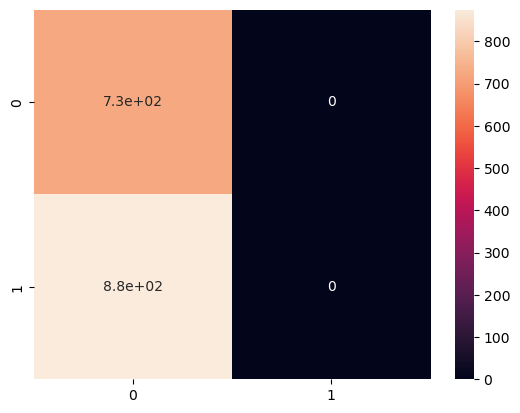

In [115]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.array(modelResults["realValues"]), np.array(modelResults["estimatedValues"]))
import seaborn as sns
sns.heatmap(cf, annot=True)

In [122]:
from tensorflow.keras import layers

def create_LSTM_model(x_train, y_train, lays, batch_size, epochs):
    model = keras.Sequential()

    model.add(layers.LSTM(lays[0], return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2]), activation="relu"))

    for i in range(1,len(lays)-1):
        model.add(layers.LSTM(int(lays[i]), return_sequences=True))

    model.add(layers.LSTM(lays[-1]))
    
    model.add(layers.Dense(1, activation = "relu"))

    # model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                #    activation=['tanh', 'tanh'])
    # model.fit(x_data, y_data, epochs=20, batch_size=1, verbose=2)

    model.summary()

    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs= epochs)

    return model

lays = [100,200,100]
model = create_LSTM_model(x_train, y_train, lays, 100, 20)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1, 100)            42000     
                                                                 
 lstm_23 (LSTM)              (None, 1, 200)            240800    
                                                                 
 lstm_24 (LSTM)              (None, 100)               120400    
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 403,301
Trainable params: 403,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
13/13 [==============================] - 2s 6ms/step - loss: 0.5485 - accuracy: 0.4515
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 0.5485 - 

<Axes: >

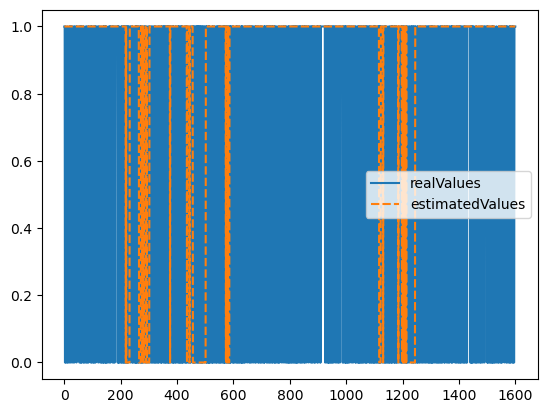

In [ ]:
seaborn.lineplot(modelResults.loc[:,["realValues", "estimatedValues"]])

<Axes: >

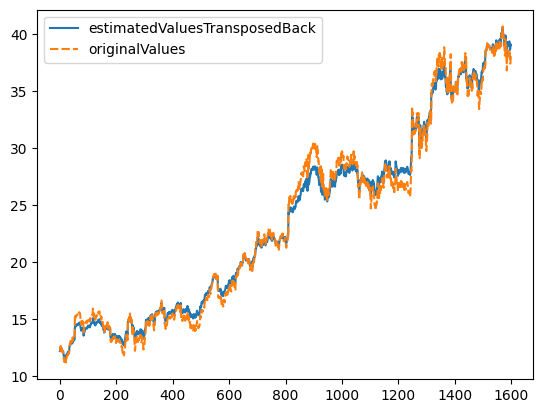

In [ ]:
seaborn.lineplot(modelResults.loc[:,["estimatedValuesTransposedBack", "originalValues"]])

Epoch 1/20
1299/1299 - 1s - loss: 0.4846 - accuracy: 0.0000e+00 - 698ms/epoch - 538us/step
Epoch 2/20
1299/1299 - 0s - loss: 0.1631 - accuracy: 0.0000e+00 - 420ms/epoch - 324us/step
Epoch 3/20
1299/1299 - 0s - loss: 0.1597 - accuracy: 0.0000e+00 - 426ms/epoch - 328us/step
Epoch 4/20
1299/1299 - 0s - loss: 0.1594 - accuracy: 0.0000e+00 - 424ms/epoch - 326us/step
Epoch 5/20
1299/1299 - 0s - loss: 0.1586 - accuracy: 0.0000e+00 - 425ms/epoch - 327us/step
Epoch 6/20
1299/1299 - 0s - loss: 0.1580 - accuracy: 0.0000e+00 - 415ms/epoch - 319us/step
Epoch 7/20
1299/1299 - 0s - loss: 0.1573 - accuracy: 0.0000e+00 - 406ms/epoch - 313us/step
Epoch 8/20
1299/1299 - 0s - loss: 0.1569 - accuracy: 0.0000e+00 - 436ms/epoch - 336us/step
Epoch 9/20
1299/1299 - 0s - loss: 0.1570 - accuracy: 0.0000e+00 - 460ms/epoch - 354us/step
Epoch 10/20
1299/1299 - 0s - loss: 0.1566 - accuracy: 0.0000e+00 - 447ms/epoch - 344us/step
Epoch 11/20
1299/1299 - 0s - loss: 0.1563 - accuracy: 0.0000e+00 - 430ms/epoch - 331us/st

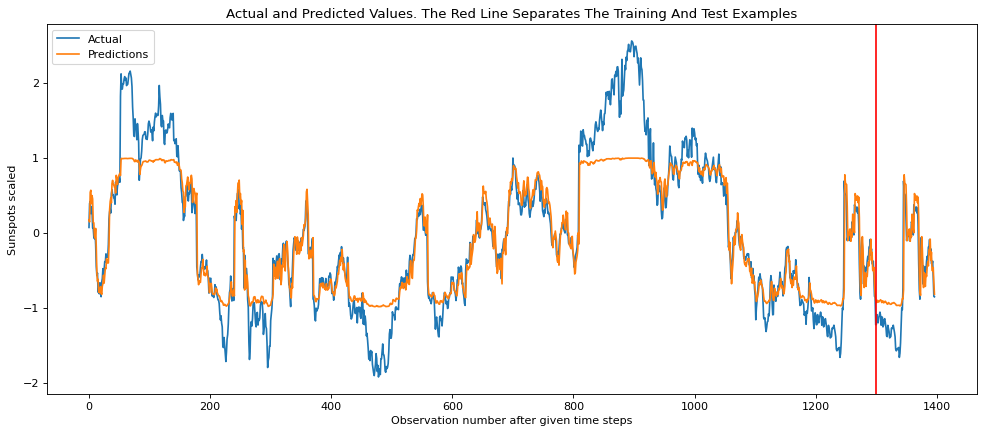

In [ ]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
    return model
 
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
 
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 1
train = (train - np.mean(train))/np.std(train)
train_data = train[0:1200]
test_data = train[1201:1600]
trainX, trainY = get_XY(train, time_steps)
testX, testY = get_XY(test_data, time_steps)


# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
 
# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [ ]:
print(trainX)
print(trainY)
print(len(train))

[[[ 0.09034692]]

 [[ 0.07143482]]

 [[ 0.39040822]]

 ...

 [[-0.37753029]]

 [[-0.58894029]]

 [[-0.8480157 ]]]
[ 0.07143482  0.39040822  0.41795966 ... -0.58894029 -0.8480157
 -0.8535417 ]
1300
